In [135]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.optimize as opt
from scipy.io import loadmat as lm

def ltr(lbl):
    return str(round(lbl*100.)/100.)

# PART 3: 1 Versus All Handwritten Digit Classification
Finally, we will move our logistic regression classification to image data. Here we have a data file containing 500 examples each of digits 0-9. This is "labeled data", so each individual image is assigned a "true" value. In supervised ML this is the "training set". You could split the training set in two and use half the labeled data as a "verification set", but I'm not going to bother. 

First we'll define the cost and gradient functions as in previous examples:

In [149]:
def sigmoid(z):
    return 1./(1.+np.exp((-1.)*z))

def h(theta,x):

    zz = np.sum(theta*x,axis=1)
    
    return sigmoid(zz)

def cost(theta,x,y,lam=0.01):

    f1 = (-1.)*y*np.log(h(theta,x))
    f2 = (y-1.)*np.log(1.-h(theta,x))
    f3 = np.sum(theta**2.)
    return (np.sum(f1+f2)+((lam/2.)*f3))/float(len(y))


def grad(theta,x,y,lam=0.01):

    f1 = np.sum((h(theta,x)-y)*x.transpose(),axis=1)+(lam*theta)
    f1[0] -= (lam*theta[0])
    return f1/float(len(y))

# THIS FUNCTION WILL SHOW AN INDIVIDUAL DIGIT (OR SIMILAR) ON AXIS = ax
def plot_one(x,ax,t_cm=cm.Greys_r,fxd=False):
    im = x.reshape((20,20))
    if not fxd:
        ax.imshow(im.transpose(),origin='upper',cmap=t_cm)
    else:
        ax.imshow(im.transpose(),origin='upper',cmap=t_cm,vmin=-5,vmax=5)
    ax.set_xticks([])
    ax.set_yticks([])

Lets load in the data and have a look at it. The data was provided as some kind of matlab file, it gets read in by scipy and comes out as a dictionary. Data labeled 'X' is the 5000 individual digits as a 5000x400 matrix where each row is the 20x20 image as a 1D vector of length 400. The data labeled 'Y' is the actual value of the digit with 10 representing 0. 

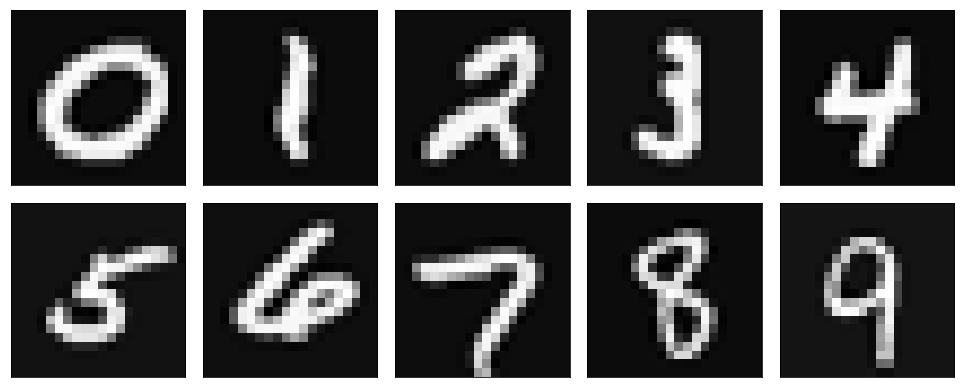

In [146]:
data = lm('ex3data1')
X,Y  = data['X'],data['y']

F = plt.figure(figsize=(13.5,5.5))
for i,y in enumerate(np.unique(Y)):
    ax  = F.add_subplot(2,5,i+1)
    ind = np.random.randint(i*500,(i+1)*500,1)
    plot_one(X[ind],ax)
plt.tight_layout()
plt.show()
    

Given the logistic regression technique is binary, we can not create a full classifier for this problem. Using the framework developed in previous examples we can simply choose one digit and train a network to say whether a given digit is or isn't the chosen value. For example, lets say we want to create a network to identify the digit 3. To do this, we first need to reformat the labels so that all non-three digits are labeled 0 and all 3s are labeled 1:

In [147]:
t = np.where(Y == 3)[0]
y = np.zeros(Y.shape[0])
y[t] = 1

So how exactly will we parameterise our model? In the case of this image data, every single pixel in each image is assigned a parameter, thus the resulting trained model can be visualised as an image. First, remember that we need to add a bias parameter as well, so we first need to add a column of 1s to the input "X" data. This means that now each of our input digits is represented by a 401 length, 1D vector. Similarly we will be optimising a parameter vector, theta, with length 401:

In [139]:
x = np.zeros((X.shape[0],X.shape[1]+1))+1.
x[:,1:] = np.copy(X)
T = np.zeros(x.shape[1])

Now we will train our model with logistic regression in the exact same way as the previous example, however we now have 401 parameters to train:

In [140]:
Res = opt.minimize(fun = cost,
                       x0 = T,
                       args = (x,y),
                       method = 'TNC',
                       jac = grad)

opt_T = Res.x

Now lets visualise the results:

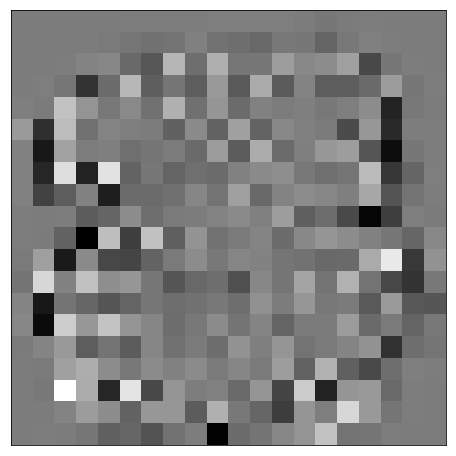

In [141]:
F  = plt.figure(figsize=(8,8))
ax = F.add_subplot(111)
plot_one(opt_T[1:],ax)
plt.show()

The resulting "image" is our trained network for identifying 3's. The way it works is that you multiply, pixel by pixel, this "image" by a given digit, sum up all the resulting values, then take the sigmoid function. The result is the predicted probability that the given digit is a 3. Thus, this image shows the optimal pixel weighting such that the multiplied and summed value will be a fairly large positive number for 3s (i.e. the sigmoid will give 1) and a fairly large negative number for non-3s (sigmoid gives 0). Lets look at a couple of examples:

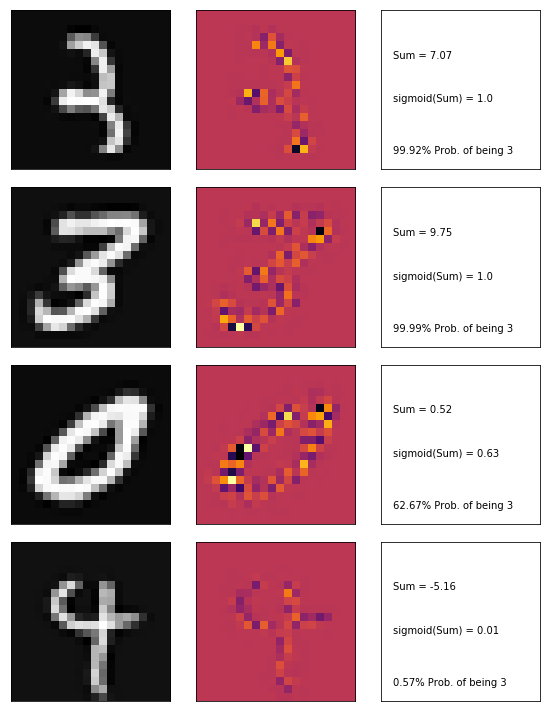

In [172]:
# SELECT TWO 3s and TWO NON-3s
i3_1,i3_2 = np.random.randint(1500,2000,1),np.random.randint(1500,2000,1)
in_1,in_2 = np.random.randint(0,1500,1),np.random.randint(2000,5000,1)
inds = [i3_1,i3_2,in_1,in_2]

F  = plt.figure(figsize=(8,10))
for i,im  in enumerate(inds):
    nax = (i*3)+1
    ax = F.add_subplot(4,3,nax)
    plot_one(X[im],ax)
    ax = F.add_subplot(4,3,nax+1)
    plot_one(X[im]*opt_T[1:],ax,fxd=True,t_cm=cm.inferno)
    ax = F.add_subplot(4,3,nax+2)
    plot_one(X[im]*0.,ax,t_cm=cm.Greys)
    
    tm_sum = np.sum(X[im]*opt_T[1:])
    ax.annotate(f'Sum = {ltr(tm_sum)}',xy=(1,5.5))
    ax.annotate(f'sigmoid(Sum) = {ltr(sigmoid(tm_sum))}',xy=(1,11))
    ax.annotate(f'{ltr(100.*sigmoid(tm_sum))}% Prob. of being 3',xy=(1,17.5))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()
    
    

The top two are threes and the bottom two arent. If you run this a few times you'll notice its good at identifying threes, but occasionally gives false positives.

For fun, lets compute the models for all 10 digits and have a look:

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


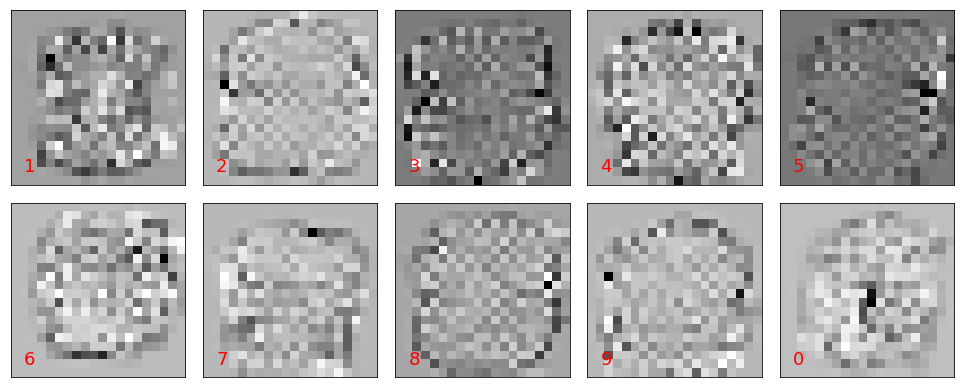

In [178]:
F = plt.figure(figsize=(13.5,5.5))
for i,y in enumerate(np.unique(Y)):
    ax  = F.add_subplot(2,5,i+1)
    
    x = np.zeros((X.shape[0],X.shape[1]+1))+1.
    x[:,1:] = np.copy(X)
    T  = np.zeros(x.shape[1])
    
    t = np.where(Y == y)[0]
    y = np.zeros(Y.shape[0])
    y[t] = 1
    
    Res = opt.minimize(fun=cost,
                         x0=T,
                         args=(x,y),
                         method='TNC',
                         jac=grad)
    
    opt_T = Res.x
    plot_one(opt_T[1:],ax)
    lb = str(i+1)
    if i == 9:
        lb = '0'
    ax.annotate(lb,fontsize=18,xy=(1,18),color='r')
    
    
plt.tight_layout()
plt.show()

This is the end of my quick summary of logistic regression for 1 versus all handwritten digit identification. Of course this is very basic machine learning and a full digit classifier (not 1 vs all) is of course a solved problem. This requires the use of neural networks, which you've probably heard of. In the context of the above digit classification problem, a neural network will work in a very similar way, but instead of returning a single probability for a given input digit you should get 10 probabilities for each possible digit.

In the coursera course they provide the trained neural network at this point as two sets of parameters. These correspond to two "layers" of the neural network with the first layer (a "hidden layer") represented by a 25x401 matrix. You can think of it as 25 different images like those above that are multiplied by the input digit, then passed through the sigmoid function, these are what we call "features". The second layer (output layer here) is represented by a 10x26 matrix (26 because you add a bias term to the hidden layer!) which is multiplied by the hidden layer. The result is passed through the sigmoid function again, resulting in a vector of length 10.

For completeness I'll show how this is implemented:

In [181]:
# READING THE PROVIDED WEIGHTS
nn_weights = lm('ex3weights.mat')
T1,T2 = nn_weights['Theta1'],nn_weights['Theta2']
print('Theta 1 shape = ',T1.shape)
print('Theta 2 shape = ',T2.shape)
print('\n\n')



Theta 1 shape =  (25, 401)
Theta 2 shape =  (10, 26)





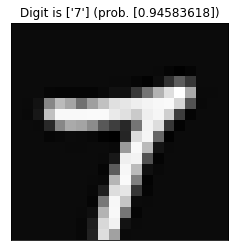

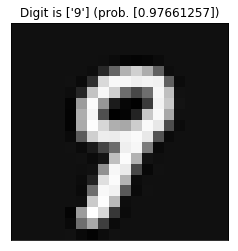

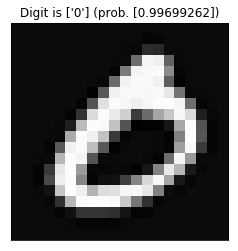

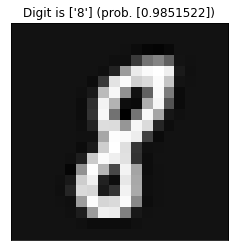

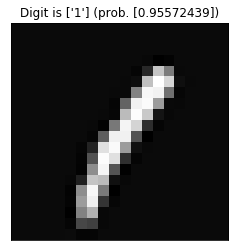

In [183]:
# COPYING THETA 1 and THETA 2 ACROSS A 3RD DIMENSION OF SIZE 5000
# (AVOIDS LOOPING)
t1 = np.zeros((T1.shape[0],T1.shape[1],x.shape[0]))
t2 = np.zeros((T2.shape[0],T2.shape[1],x.shape[0]))
for i in range(x.shape[0]):
    t1[:,:,i] = np.copy(T1)
    t2[:,:,i] = np.copy(T2)

# FORWARD PROPOGATING THE MODEL AND PROVIDING PREDICTIONS
l1 = sigmoid(np.sum(t1*x.transpose(),axis=1))
layer_1 = np.zeros((l1.shape[0]+1,l1.shape[1]))+1.
layer_1[1:,:] = np.copy(l1)
pred = sigmoid(np.sum(layer_1*t2,axis=1)).transpose()

# SHOWING A FEW EXAMPLES:
nex = 5
labels = np.array(['1','2','3','4','5','6','7','8','9','0'])
for i in range(nex):
    ex = np.random.randint(0,4999)

    tp = np.where(pred[ex] == np.max(pred[ex]))[0]
    pr = pred[ex][tp]
    tt = f'Digit is {labels[tp]} (prob. {pr})'

    F  = plt.figure()
    ax = F.add_subplot(111)
    plot_one(X[ex],ax)
    ax.set_title(tt)
    plt.show()